## Here, we make the lane detection model:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import glob
from torch.utils.data import random_split, Subset
import statistics
import cv2
import numpy as np
import matplotlib.pyplot as plt

C:\Users\kavya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Den angitte prosedyren ble ikke funnet'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Import images:

In [2]:
label_paths = sorted(glob.glob('./labels/*.jpg'))
image_paths = sorted(glob.glob('./frames_subset/*.jpg'))

Preprocess data:

In [3]:
def binarise(label):
    return (label > 0).float()

In [4]:
class LaneDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx]).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = binarise(mask)

        return image, mask

In [22]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))
])

Split data:

In [23]:
lane_data = LaneDataset(image_paths, label_paths, transform=transform)

train_size = int(0.8 * len(lane_data))
test_size = len(lane_data) - train_size

lane_train, lane_test = random_split(lane_data, [train_size, test_size])

In [25]:
test_loader = DataLoader(lane_test, batch_size=1, shuffle=True)

Designing CNN model:

In [32]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)

        self.conv5 = nn.Conv2d(128, 1, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)

        x = torch.sigmoid(x)
        return x

Training loop:

In [33]:
train_loader = DataLoader(lane_train, batch_size=1, shuffle=True)

model = CNN()
criterion = nn.BCELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 5

for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)

        loss = criterion(outputs, labels)

        opt.zero_grad()
        loss.backward()
        opt.step()
      

Evaluation loop:

In [87]:
model.eval()

with torch.no_grad():
    pixel_correct = 0
    pixel_total = 0
    iou_sum = 0

    for images, labels in test_loader:
        outputs = model(images)
        preds = outputs > 0.5

        preds_bool = preds.bool()
        labels_bool = labels.bool()

        pixel_correct += (preds_bool == labels_bool).sum().item()
        pixel_total += torch.numel(labels_bool)

        # IoU for each batch
        intersection = (preds_bool & labels_bool).float().sum((1, 2))
        union = (preds_bool | labels_bool).float().sum((1, 2))
        iou = (intersection + 1e-6) / (union + 1e-6)
        iou_sum += iou.sum().item()


pixel_acc = pixel_correct / pixel_total
mean_iou = iou_sum / len(test_loader.dataset)

print(f'Pixel Accuracy: {pixel_acc}')
print(f'Mean IoU: {mean_iou}')

Pixel Accuracy: 0.994990234375
Mean IoU: 1012.0


Display results:

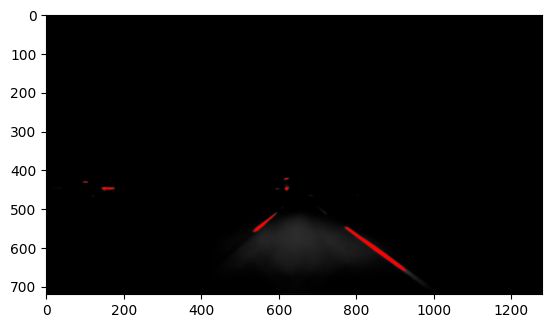

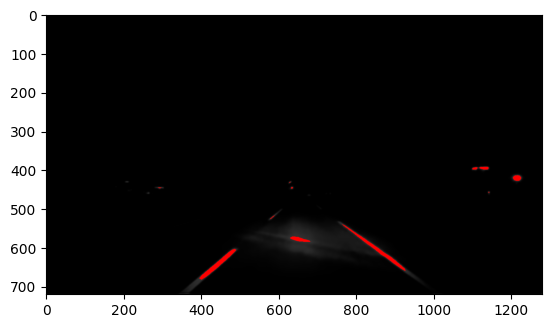

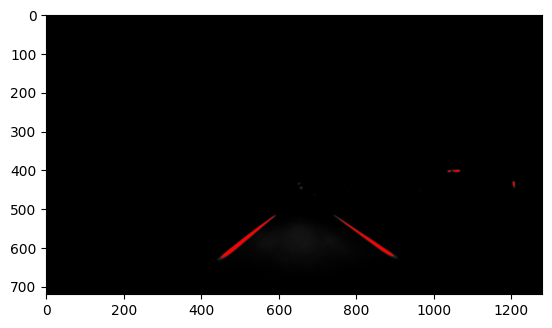

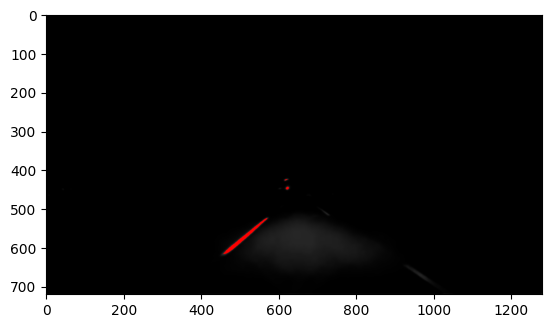

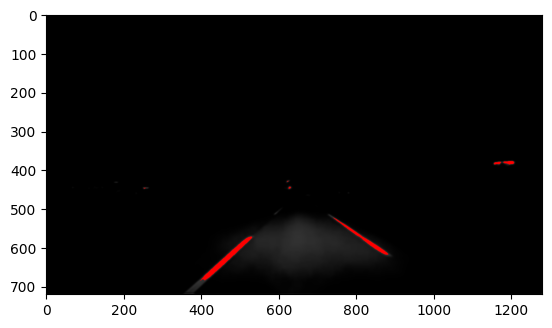

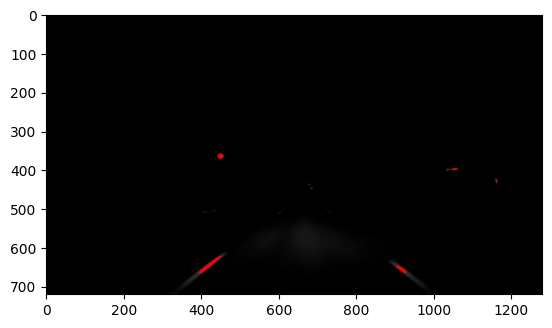

In [86]:
for i, (images, labels) in enumerate(train_loader):
    if i > 5:
        break
    outputs = model(images)
    mask = outputs.squeeze().detach().numpy()

    colored_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    colored_mask[mask > 0.2] = [1, 0, 0]
    plt.imshow(colored_mask)
    plt.show()

Use model on whole video (using OpenCV):

In [85]:
cap = cv2.VideoCapture('lane_data10.mp4')
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_size = (frame_width, frame_height)
output_fps = cap.get(cv2.CAP_PROP_FPS)

out = cv2.VideoWriter('lane_marked1.mp4', cv2.VideoWriter_fourcc(*'MP4V'), output_fps, frame_size)

model.eval()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Process frame
    input_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    input_frame_tf = transform(Image.fromarray(input_frame)).unsqueeze(0)

    # Compute output
    with torch.no_grad():
        output = model(input_frame_tf)
        mask = (output.squeeze()).numpy()

    # Denormalise and create binary mask
    mask_uint8 = (mask * 255).astype(np.uint8)

    threshold_value = 0.2 * 255
    _, binary_mask = cv2.threshold(mask_uint8, threshold_value, 255, cv2.THRESH_BINARY)


    # Set overlaying channel
    color_mask = np.zeros_like(frame)
    color_mask[:, :, 2] = binary_mask

    # Overlay the color mask with the original frame
    alpha = 0.5 
    masked_image = cv2.addWeighted(frame, alpha, color_mask, 1, 0)


    #masked_image = cv2.bitwise_and(frame, frame, mask=binary_mask)
    
    out.write(masked_image)

cap.release()
out.release()